In [89]:
import cv2
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image
import torchvision
import shutil

In [92]:
# create blured images
gaussian_blur = torchvision.transforms.GaussianBlur(kernel_size=256 / 10, sigma=3)
nose_dataset_dir = Path("/app/datasets/gaussian_nose")
shutil.rmtree(nose_dataset_dir, ignore_errors=True)
loose_crop_path = nose_dataset_dir / "loose_crop"
nose_dataset_dir.mkdir(exist_ok=True)
loose_crop_path.mkdir(exist_ok=True)
nose_iteration_size = 15
probe_image_index = 1
ids = [0, 1, 2]

for id in ids:
    probe_image_path = Path("/app/datasets/interpolation/loose_crop") / (
        str(id) + "_" + str(probe_image_index).zfill(4) + ".jpg"
    )
    initial_image = plt.imread(probe_image_path)
    plt.imsave(
        loose_crop_path
        / (str(id) + f"_{probe_image_index}_" + str(0).zfill(4) + ".jpg"),
        initial_image,
    )
    blured_images = [initial_image]
    for i in range(nose_iteration_size):
        prev_image = Image.fromarray(blured_images[-1])
        new_image = gaussian_blur(prev_image)
        blured_images.append(np.array(new_image))
        plt.imsave(
            loose_crop_path
            / (str(id) + f"_{probe_image_index}_" + str(i + 1).zfill(4) + ".jpg"),
            np.array(new_image),
        )
        # plt.imshow(new_image)

In [93]:
# create meta file
meta_dir = nose_dataset_dir / "meta"
meta_dir.mkdir(exist_ok=True)

with open("/app/datasets/interpolation/meta/inter_name_5pts_score.txt") as fd:
    img_records = np.array([ii.strip().split(" ") for ii in fd.readlines()])
landmarks = img_records[:, 1:-1].astype("float32")  # .reshape(-1, 5, 2)
id_to_landmarks = {}

with open(meta_dir / "nose_name_5pts_score.txt", "w") as fd:
    for id in range(3):
        landmark = landmarks[id * 9 + probe_image_index]
        id_to_landmarks[id] = landmark
        landmark = landmark.astype("str").tolist()
        rows = [
            [
                str(id) + f"_{probe_image_index}_" + str(0).zfill(4) + ".jpg",
                *landmark,
                str(1.0),
            ]
        ]
        for i in range(nose_iteration_size):
            name = str(id) + f"_{probe_image_index}_" + str(i + 1).zfill(4) + ".jpg"
            rows.append([name, *landmark, str(1.0)])
        for data in rows:
            fd.write(" ".join(data) + "\n")

In [94]:
# load probe embeddings

id_to_gallery_emb = {id: [] for id in range(3)}
embs = np.load("/app/cache/features/scf_embs_inter.npz")
for i in range(3):
    id_to_gallery_emb[i].append(embs["embs"][i * 9 + 0][np.newaxis, :])
    id_to_gallery_emb[i].append(embs["embs"][i * 9 + 8][np.newaxis, :])

id_to_probe_emb = {id: [] for id in range(3)}
id_to_probe_unc = {id: [] for id in range(3)}
embs_probe = np.load("/app/cache/features/scf_embs_nose.npz")
for id in range(3):
    for i in range(nose_iteration_size + 1):
        id_to_probe_emb[id].append(
            embs_probe["embs"][id * (nose_iteration_size + 1) + i]
        )
        id_to_probe_unc[id].append(
            embs_probe["unc"][id * (nose_iteration_size + 1) + i, 0]
        )

In [110]:
from hydra.utils import instantiate

T = 0.28836
T_data_unc = 5
power_recognition_method = {
    "_target_": "evaluation.open_set_methods.posterior_prob_based.PosteriorProbability",
    "class_model": "power",
    "kappa": 0.3,
    "beta": 0.5,
    "uncertainty_type": "maxprob",
    "alpha": 0,
    "aggregation": "sum",
    "T": T,
    "T_data_unc": T_data_unc,
    "kappa_is_tau": True,
}

scf_recognition_method = {
    "_target_": "evaluation.open_set_methods.posterior_prob_based.PosteriorProbability",
    "class_model": "power",
    "kappa": 0.3,
    "beta": 0.5,
    "uncertainty_type": "maxprob",
    "alpha": 1,
    "aggregation": "sum",
    "T": T,
    "T_data_unc": T_data_unc,
    "kappa_is_tau": True,
}

sum_recognition_method = {
    "_target_": "evaluation.open_set_methods.posterior_prob_based.PosteriorProbability",
    "class_model": "power",
    "kappa": 0.3,
    "beta": 0.5,
    "uncertainty_type": "maxprob",
    "alpha": 0.5,
    "aggregation": "sum",
    "T": T,
    "T_data_unc": T_data_unc,
    "kappa_is_tau": True,
}

power_unc_predictor = instantiate(power_recognition_method)
scf_unc_predictor = instantiate(scf_recognition_method)
sum_unc_predictor = instantiate(sum_recognition_method)

Tau 0.3, kappa 363.52
Tau 0.3, kappa 363.52
Tau 0.3, kappa 363.52
Tau 0.3, kappa 363.52
Tau 0.3, kappa 363.52
Tau 0.3, kappa 363.52
Tau 0.3, kappa 363.52
Tau 0.3, kappa 363.52
Tau 0.3, kappa 363.52


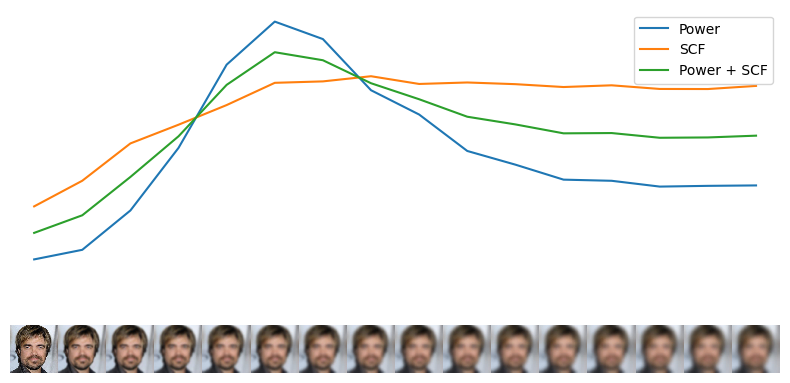

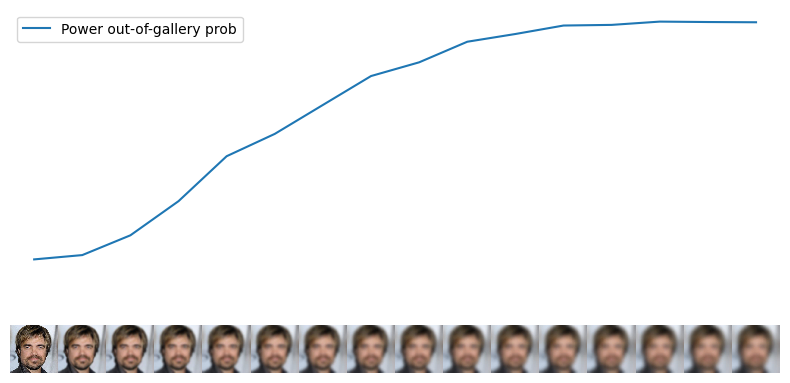

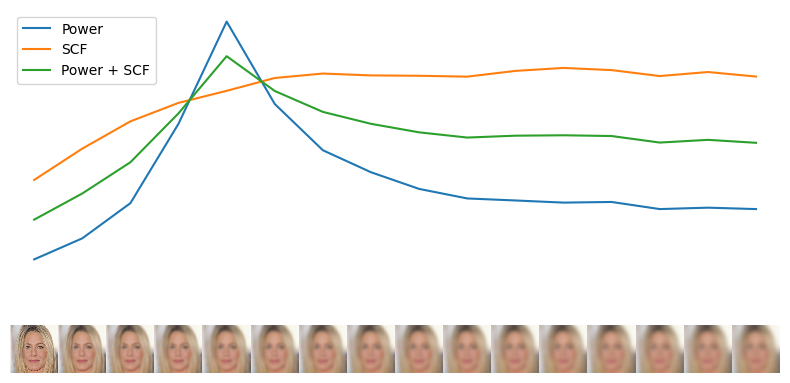

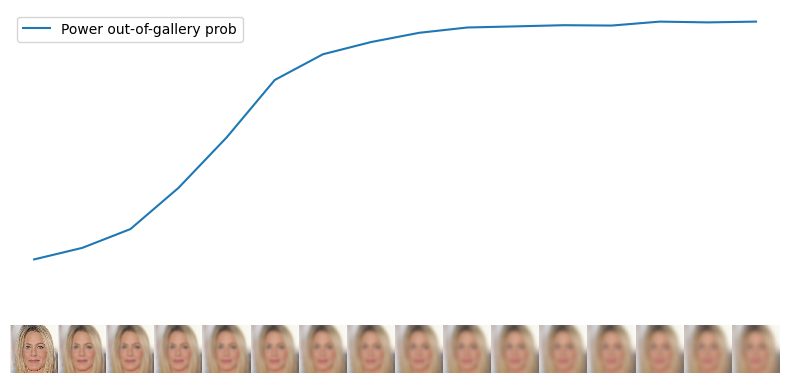

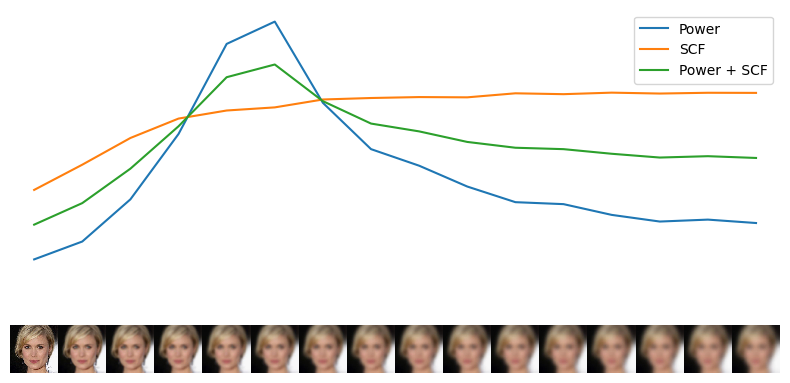

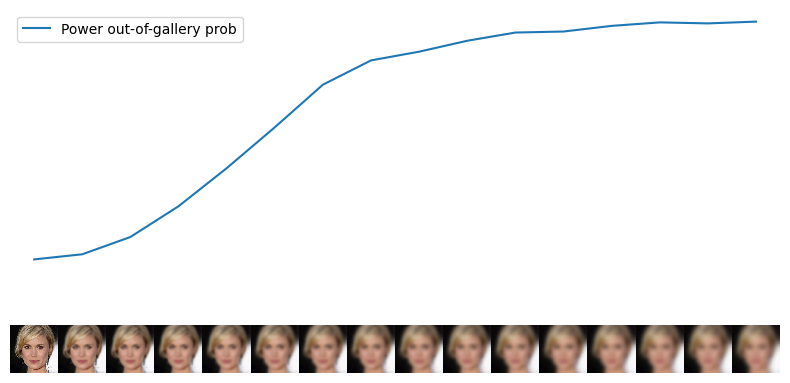

In [116]:
# compute uncertainty and create plots
test_id = 1
ids = [0, 1, 2]
for test_id in ids:
    fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8, 5), frameon=False)
    gallery_embeddings = np.concatenate(id_to_gallery_emb[test_id])

    probe_embeddings = []
    for j in np.arange(0, nose_iteration_size + 1):
        probe_embeddings.append(id_to_probe_emb[test_id][j])
    probe_embeddings = np.array(probe_embeddings)

    similarity_matrix = probe_embeddings @ gallery_embeddings.T
    similarity_matrix = similarity_matrix[:, np.newaxis, :]

    # compute unc
    power_unc_predictor.setup(similarity_matrix)
    scf_unc_predictor.setup(similarity_matrix)
    sum_unc_predictor.setup(similarity_matrix)

    probe_kappa = np.exp(id_to_probe_unc[test_id])[:, np.newaxis]
    power_predicted_unc = power_unc_predictor.predict_uncertainty(probe_kappa)
    power_probs = np.exp(power_unc_predictor.all_classes_log_prob)
    scf_predicted_unc = scf_unc_predictor.predict_uncertainty(probe_kappa)
    sum_predicted_unc = sum_unc_predictor.predict_uncertainty(probe_kappa)

    scale = 256
    shift = 256 / 2
    x = np.arange(nose_iteration_size + 1) * scale + shift

    axs[0].plot(x, power_predicted_unc * scale, label="Power")
    axs[0].plot(x, scf_predicted_unc * scale, label="SCF")
    axs[0].plot(x, sum_predicted_unc * scale, label="Power + SCF")
    axs[0].axis("off")
    axs[0].legend()

    blured_images = []
    for i in range(nose_iteration_size + 1):
        image_path = str(
            loose_crop_path
            / (str(test_id) + f"_{probe_image_index}_" + str(i).zfill(4) + ".jpg")
        )
        blured_images.append(plt.imread(image_path))
    # gallery images outline
    axs[1].imshow(np.concatenate(blured_images, axis=1), interpolation="none")
    axs[1].axis("off")
    fig.tight_layout()
    fig.savefig(
        f"/app/paper_assets/images/nose_{test_id}",
        dpi=300,
        bbox_inches="tight",
        pad_inches=0,
    )
    fig_prob, axs_prob = plt.subplots(2, 1, sharex=True, figsize=(8, 5), frameon=False)
    axs_prob[0].plot(x, power_probs[:, -1] * scale, label="Power out-of-gallery prob")
    axs_prob[0].axis("off")
    axs_prob[0].legend()
    axs_prob[1].imshow(np.concatenate(blured_images, axis=1), interpolation="none")
    axs_prob[1].axis("off")
    fig_prob.tight_layout()
    fig_prob.savefig(
        f"/app/paper_assets/images/nose_{test_id}_prob",
        dpi=300,
        bbox_inches="tight",
        pad_inches=0,
    )

In [112]:
nose_iteration_size

15